In [1]:
!pip install -q libtiff
!pip install -q tqdm

In [2]:
from pathlib import Path
from libtiff import TIFF
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import tensorflow as tf
from google.colab import drive
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras import regularizers, layers
from tensorflow.keras.callbacks import Callback 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
np.random.seed(1024)

In [4]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [5]:
PROJECT_DIR = 'нейросети/'
EVALUATE_ONLY = True
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')

In [6]:
class Dataset:
    def __init__(self, name, gdrive_dir):
        self.name = name
        self.frame_path = os.path.join("/content/drive/MyDrive/", PROJECT_DIR, self.name)
        self.is_loaded = False
        p = Path("/content/drive/MyDrive/"+ gdrive_dir + name+'.npz')
        if p.exists():
            print(f'Loading dataset {self.name} from npz.')
            np_obj = np.load(str(p))
            self.images = np_obj['data']
            self.labels = np_obj['labels']
            self.n_files = self.images.shape[0]
            self.is_loaded = True
            print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]
  
    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]
#LBL7
    def create_frame(self):
      df_data = []
      for id, (img, label) in tqdm(enumerate(zip(self.images, self.labels))):
        im = Image.fromarray(img)
        im.save(os.path.join(self.frame_path, f'{id}.jpg'))
        df_data.append([f'{id}.jpg', label])
      df = pd.DataFrame(df_data, columns=['id', 'label'])
      df.to_csv(os.path.join(self.frame_path, 'index.csv'))

In [7]:
class Metrics:
    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

In [8]:
class LivePlotting(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure(figsize=(32, 20))
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)

        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        #LBL4
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        if len(self.val_losses) > 1:
          ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        if len(self.val_acc) > 1:
          ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show()
        #LBL3
        print(f"{logs} \n best_val_acc : {np.max(self.val_acc)} \n best_val_loss : {np.min(self.val_losses)}")

In [9]:
callbacks = {
    #LBL2
    'best_loss_checkpoint' : tf.keras.callbacks.ModelCheckpoint(
          filepath=os.path.join("/content/drive/MyDrive/", PROJECT_DIR, 'best_loss'), monitor='loss', verbose=2, save_best_only=True,
          save_weights_only=False, mode='min', save_freq='epoch'
    ),
    'best_val_acc_checkpoint' : tf.keras.callbacks.ModelCheckpoint(
          filepath=os.path.join("/content/drive/MyDrive/", PROJECT_DIR, 'best_val_acc'), monitor='val_accuracy', verbose=2, save_best_only=True,
          save_weights_only=False, mode='max', save_freq='epoch'
     ),
    'live_plotting' : LivePlotting()
}

In [10]:
class Model:
    def __init__(self):
        self.model = tf.keras.models.Sequential([
            tf.keras.Input(shape=(224, 224, 3)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
            tf.keras.layers.AveragePooling2D((2, 2), padding='same'),
            
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.AveragePooling2D((2, 2), padding='same'),
            
            tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.AveragePooling2D((2, 2), padding='same'),

            tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.AveragePooling2D((2, 2), padding='same'),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(9, activation='softmax')
        ])

        
        opt=tf.keras.optimizers.Adam()

        self.model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
        #LBL6
        self.train_datagen = ImageDataGenerator(
            rotation_range = 360,
            width_shift_range = 0.1,
            height_shift_range = 0.1, 
            zoom_range = 0.1,
            rescale=1/255.
        )

        self.test_datagen = ImageDataGenerator(
            rescale=1/255.)

    def summary(self):
        self.model.summary()

    def save(self, name: str):
        self.model.save(os.path.join("/content/drive/MyDrive/", PROJECT_DIR, name))

    def load(self, name: str):
        self.model = tf.keras.models.load_model(os.path.join("/content/drive/MyDrive/", PROJECT_DIR, name))

    def train(self, dataset: Dataset, EPOCH_NUM : int=3):

        train_images, train_labels = dataset.load_data()
        self.train_datagen.fit(train_images)


        print('training started')
        self.model.fit(self.train_datagen.flow(train_images.astype('float32'), train_labels), 
                       callbacks = [callbacks['best_loss_checkpoint'], callbacks['live_plotting']],
                       epochs=200, 
                       verbose=1)
        print('training done')


    def train_validate(self, train_dataset: Dataset, test_dataset: Dataset, EPOCH_NUM : int=3):

      self.train_datagen.fit(train_dataset.images)
      self.test_datagen.fit(test_dataset.images)


      print('training started')
      self.model.fit(self.train_datagen.flow(train_dataset.images.astype('float32'), train_dataset.labels, batch_size=32), 
                     #LBL5
                     validation_data=self.test_datagen.flow(test_dataset.images.astype('float32'), test_dataset.labels),
                     callbacks = [callbacks['best_val_acc_checkpoint'], callbacks['live_plotting']],
                     epochs=EPOCH_NUM, 
                     verbose=1,
                     batch_size=200,
                     workers=8)
      print('training done')
#LBL7
    def train_validate_from_frame(self, train_dataset: Dataset, test_dataset: Dataset, EPOCH_NUM : int=3):

      train_df = pd.read_csv(os.path.join(train_dataset.frame_path, 'index.csv'))
      test_df = pd.read_csv(os.path.join(test_dataset.frame_path, 'index.csv'))

      train_generator = self.train_datagen.flow_from_dataframe(
          dataframe=train_df,
          directory = train_dataset.frame_path,
          x_col='id',
          y_col='label',
          batch_size=32,
          target_size=(224, 224),
          shuffle=True,
          seed=1024,
          class_mode='raw'
      )

      test_generator = self.test_datagen.flow_from_dataframe(
          dataframe=test_df,
          directory = test_dataset.frame_path,
          x_col='id',
          y_col='label',
          batch_size=32,
          target_size=(224, 224),
          shuffle=True,
          seed=1024,
          class_mode='raw'
      )

      print('training started')
      self.model.fit_generator(train_generator, 
                     #LBL5          
                     validation_data=test_generator,
                     callbacks = [callbacks['best_val_acc_checkpoint'], callbacks['live_plotting']],
                     epochs=EPOCH_NUM, 
                     verbose=1,
                     workers=8)
      print('training done')
#LBL1   
    def test_on_dataset(self, dataset: Dataset, limit=None):
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)


        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img.reshape(1, *img.shape)))
        return predictions

    def test_on_image(self, img: np.ndarray):
        return np.argmax(self.model.predict(img/255.))

In [11]:
d_train = Dataset('train', PROJECT_DIR)
d_test = Dataset('test', PROJECT_DIR)

Loading dataset train from npz.
Done. Dataset train consists of 18000 images.
Loading dataset test from npz.
Done. Dataset test consists of 4500 images.


In [12]:
model = Model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
average_pooling2d (AveragePo (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
average_pooling2d_2 (Average (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2

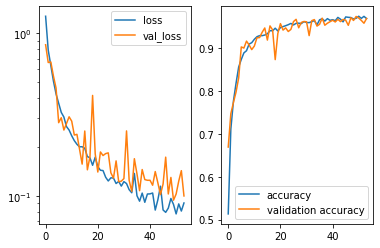

{'loss': 0.0906452164053917, 'accuracy': 0.968999981880188, 'val_loss': 0.10013676434755325, 'val_accuracy': 0.9693333506584167} 
 best_val_acc : 0.9739999771118164 
 best_val_loss : 0.09431356936693192
Epoch 55/200
326/563 [================>.............] - ETA: 1:15 - loss: 0.0678 - accuracy: 0.9759

In [ ]:
model.train_validate_from_frame(d_train, d_test, EPOCH_NUM=200)

In [ ]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

In [ ]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test', PROJECT_DIR)
pred = final_model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')